In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import Library

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt;

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, LSTM

from tensorflow import keras
from tensorflow.keras import layers

import plotly.graph_objs as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
cols = ['date', 'sales']
df = pd.read_csv('/content/drive/MyDrive/Train.csv', names=cols, header=0)
df_test = pd.read_csv('/content/drive/MyDrive/Test.csv', names=cols, header=0)

In [ ]:
bulan_ke_angka = {
    'Jan': '01',
    'Feb': '02',
    'Mar': '03',
    'Apr': '04',
    'May': '05',
    'Jun': '06',
    'Jul': '07',
    'Aug': '08',
    'Sep': '09',
    'Oct': '10',
    'Nov': '11',
    'Dec': '12'
}

# Mengubah format tanggal
df['date'] = df['date'].apply(lambda x: bulan_ke_angka[x[:3]] + x[-3:])
df_test['date'] = df_test['date'].apply(lambda x: bulan_ke_angka[x[:3]] + x[-3:])

In [ ]:
df.head()

,date,sales
0,01-98,126.0
1,02-98,201.0
2,03-98,200.0
3,04-98,139.0
4,05-98,149.0


# Exploratory Data Analysis

Cek informasi data termasuk null value

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    288 non-null    object 
 1   sales   288 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.6+ KB


In [ ]:
df.index = pd.to_datetime(df.date, format='%m-%y')
df_test.index = pd.to_datetime(df_test.date, format='%m-%y')

In [ ]:
df = df.resample("M").sum()
df_test = df_test.resample("M").sum()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 1998-01-31 to 2021-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   288 non-null    float64
dtypes: float64(1)
memory usage: 4.5 KB


In [ ]:
df.head()

,sales
date,
1998-01-31,126.0
1998-02-28,201.0
1998-03-31,200.0
1998-04-30,139.0
1998-05-31,149.0


In [ ]:
df_test.head()

,sales
date,
2022-01-31,471.93
2022-02-28,511.53
2022-03-31,263.53
2022-04-30,184.14
2022-05-31,310.00


In [ ]:
trace0= go.Scatter(
        x = df.index,
        y = df.sales,
        mode ='lines',
        name = 'Penjualan'
)

data=[trace0]
layout = go.Layout(title=f'<b>Penjualan Mobil Tahun 2023</b>', title_x=0.5, xaxis_title='date', yaxis_title='sales')

fig = go.Figure(data=data,layout=layout)
fig.show()

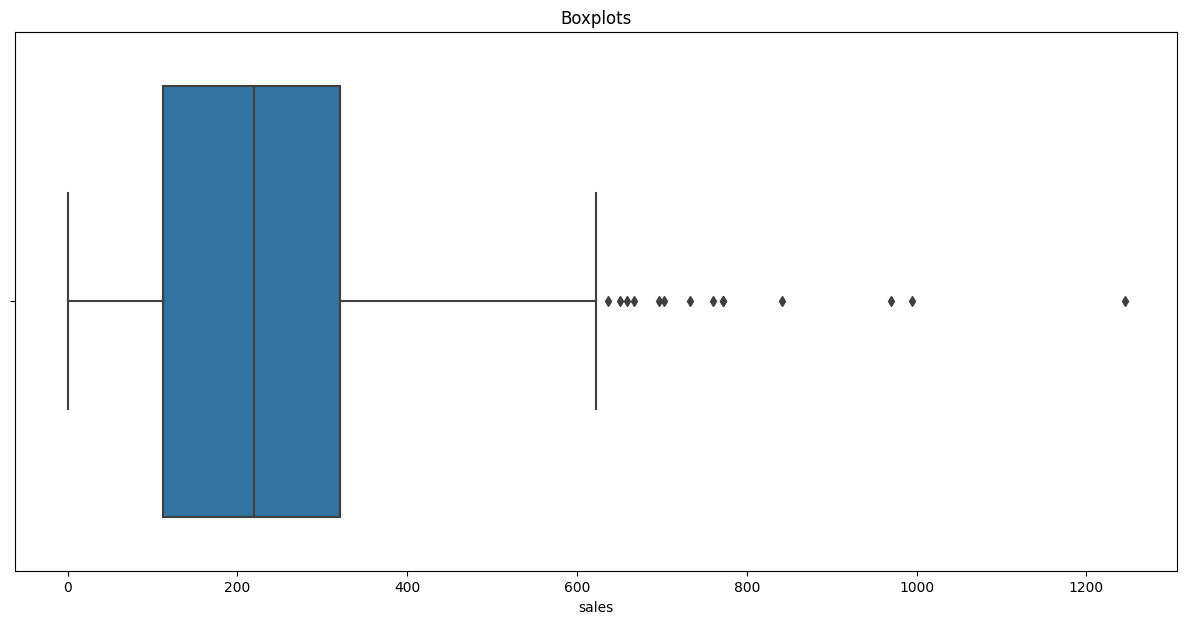

In [ ]:
plt.figure(figsize = (15 ,7))

plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
sns.boxplot(x = 'sales', data = df)
plt.title('Boxplots')

plt.show()

In [ ]:
lower_bound = 100
upper_bound = 700

median = df['sales'].median()
q1 = df['sales'].quantile(0.25)
q3 = df['sales'].quantile(0.75)

# Transformasi nilai sales yang berada di rentang tertentu
mask_low = (df['sales'] <= lower_bound)
mask_high = (df['sales'] >= upper_bound)

# Ganti nilai sales sesuai kriteria dengan nilai di antara Q1 dan Q3
df.loc[mask_low, 'sales'] = np.random.uniform(q1, median, np.sum(mask_low))
df.loc[mask_high, 'sales'] = np.random.uniform(median, q3, np.sum(mask_high))

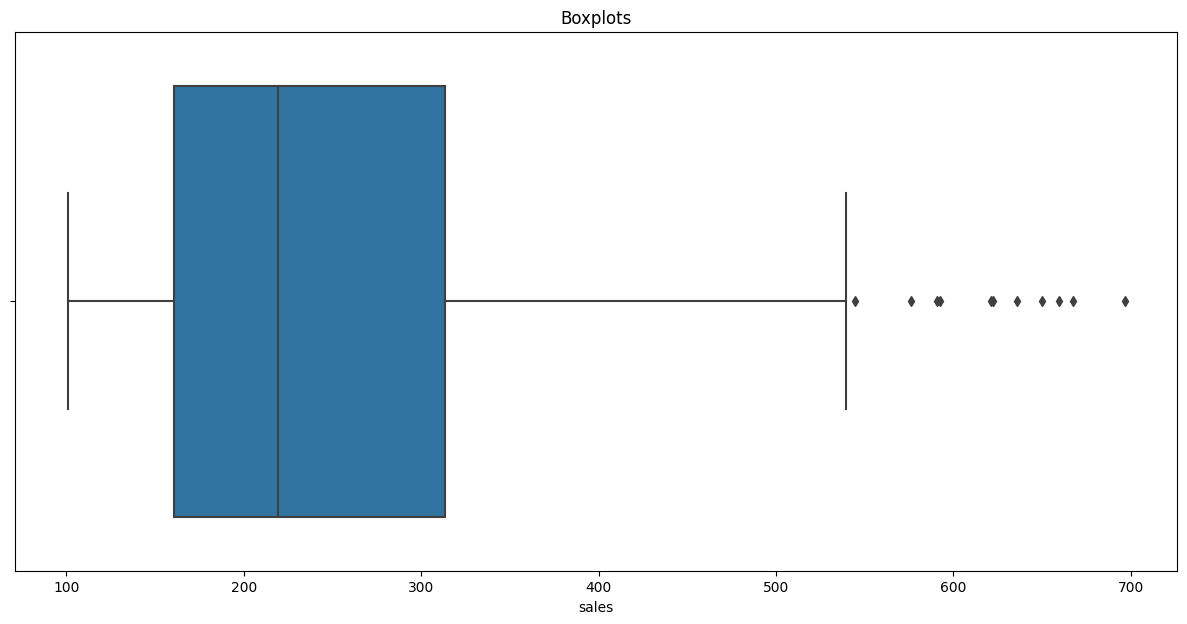

In [ ]:
plt.figure(figsize = (15 ,7))

plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
sns.boxplot(x = 'sales', data = df)
plt.title('Boxplots')

plt.show()

In [ ]:
def plot_seasonal_decompose(result:DecomposeResult, dates:pd.Series=None, title:str="Seasonal Decomposition"):
    x_values = dates if dates is not None else np.arange(len(result.observed))
    return (
        make_subplots(
            rows=4,
            cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.observed, mode="lines", name='Observed'),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.trend, mode="lines", name='Trend'),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.seasonal, mode="lines", name='Seasonal'),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.resid, mode="lines", name='Residual'),
            row=4,
            col=1,
        )
        .update_layout(
            height=900, title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False
        )
    )

In [ ]:
decomposition = seasonal_decompose(df['sales'], model='additive', period=12)
fig = plot_seasonal_decompose(decomposition, dates=df.index)
fig.show()

# Split Dataset

Dalam projek ini, akan diperkirakan penjualan mobil untuk 12 bulan ke depan.
Namun, tidak dimiliki data penjualan aktual untuk membandingkan hasil prediksi yang diperoleh sehingga tingkat kesuksesan prediksi yang diperoleh tidak dapat dilihat.

Oleh karena itu, untuk mengukur keberhasilan prediksi, akan disisihkan data 12 bulan terakhir sebagai data uji dan sisanya akan menjadi data latih.

Jadi, penjualan mobil toyota di Indonesia untuk 12 bulan ke depan akan diprediksi berdasarkan data latih dan membandingkan hasilnya dengan nilai sebenarnya yang ada di data uji.

In [ ]:
train = df[:-12]
test = df[-12:]
validate = df_test

In [ ]:
train.head()

,sales
date,
1998-01-31,126.0
1998-02-28,201.0
1998-03-31,200.0
1998-04-30,139.0
1998-05-31,149.0


In [ ]:
test.head()

,sales
date,
2021-01-31,636.000000
2021-02-28,306.384873
2021-03-31,335.400000
2021-04-30,202.270000
2021-05-31,171.400000


In [ ]:
validate.head()

,sales
date,
2022-01-31,471.93
2022-02-28,511.53
2022-03-31,263.53
2022-04-30,184.14
2022-05-31,310.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 1998-01-31 to 2021-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   288 non-null    float64
dtypes: float64(1)
memory usage: 4.5 KB


Membuat lags

In [ ]:
def lag(df, n):
    X, y = [], []
    for i in range(len(df) - n):
        X.append(df[i:i+n])
        y.append(df[n+i])

    return np.array(X), np.array(y), np.array(y[-n:]).reshape(1,n)

Memanggil fungsi lags

In [ ]:
X, y, batch_terakhir = lag(train.sales.values, 12)

In [ ]:
X

array([[126.        , 201.        , 200.        , ..., 229.        ,
        244.        , 231.        ],
       [201.        , 200.        , 139.        , ..., 244.        ,
        231.        , 211.        ],
       [200.        , 139.        , 149.        , ..., 231.        ,
        211.        , 170.        ],
       ...,
       [206.89691257, 178.26559011, 183.67      , ..., 167.94925983,
        133.5197877 , 103.73      ],
       [178.26559011, 183.67      , 659.33      , ..., 133.5197877 ,
        103.73      , 167.8       ],
       [183.67      , 659.33      , 221.64427034, ..., 103.73      ,
        167.8       , 353.07      ]])

In [ ]:
total_elemen = X.size
print("Jumlah elemen dalam X:", total_elemen)

Jumlah elemen dalam X: 3168


In [ ]:
y

array([211.        , 170.        , 292.        , 337.        ,
       204.        , 142.        , 196.        , 119.        ,
       110.        , 263.        , 299.        , 261.        ,
       477.        , 294.75      , 340.        , 172.75      ,
       142.42      , 129.92      , 137.99213302, 143.50068795,
       207.96814105, 206.75      , 347.08      , 145.33      ,
       230.        , 191.8       , 352.2       , 192.5       ,
       206.76473111, 138.5       , 141.97576269, 314.6       ,
       134.99618837, 332.5       , 696.5       , 366.6       ,
       256.2       , 170.75252915, 286.4       , 257.4       ,
       185.3       , 108.        , 287.4       , 144.04816949,
       169.7       , 124.53919006, 243.4       , 276.1       ,
       319.9       , 355.9       , 171.7       , 368.3       ,
       174.9       , 184.83107235, 163.40103465, 150.6       ,
       125.        , 277.2       , 234.3       , 267.2       ,
       441.67      , 650.17      , 370.5       , 238.25

In [ ]:
batch_terakhir

array([[659.33      , 221.64427034, 414.33      , 278.8       ,
        280.73      , 193.81172461, 167.94925983, 133.5197877 ,
        103.73      , 167.8       , 353.07      , 410.93      ]])

# Creating Model ML

Membuat fungsi untuk model Multi-Layer Perceptron

In [ ]:
def mlp(input_, y_, epochs):
    model = Sequential()
    model.add(Dense(2, activation='relu', input_dim=input_.shape[1]))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(8, activation='relu'))
    #model.add(Dense(64, activation='relu'))
    model.add(Dense(1))

    opt = keras.optimizers.Adam(learning_rate=0.0001)  # Cobalah nilai learning rate yang berbeda
    model.compile(optimizer='adam', loss='mape')

    early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=100, restore_best_weights=True)

    print(model.fit(input_, y_, epochs=epochs, callbacks=[early_stopping]))

    return model

Model yang dibuat menggunakan activation **'relu'** dan optimizer **'adam'**

## Call Model

In [ ]:
model = mlp(X, y, 3000)

Epoch 1/3000
9/9 [==============================] - 1s 2ms/step - loss: 111.7219
Epoch 2/3000
9/9 [==============================] - 0s 2ms/step - loss: 107.8036
Epoch 3/3000
9/9 [==============================] - 0s 2ms/step - loss: 104.9985
Epoch 4/3000
9/9 [==============================] - 0s 2ms/step - loss: 103.0309
Epoch 5/3000
9/9 [==============================] - 0s 3ms/step - loss: 101.3332
Epoch 6/3000
9/9 [==============================] - 0s 2ms/step - loss: 99.3847
Epoch 7/3000
9/9 [==============================] - 0s 2ms/step - loss: 96.6294
Epoch 8/3000
9/9 [==============================] - 0s 2ms/step - loss: 91.7843
Epoch 9/3000
9/9 [==============================] - 0s 2ms/step - loss: 83.7191
Epoch 10/3000
9/9 [==============================] - 0s 3ms/step - loss: 72.8441
Epoch 11/3000
9/9 [==============================] - 0s 2ms/step - loss: 62.3348
Epoch 12/3000
9/9 [==============================] - 0s 2ms/step - loss: 53.4222
Epoch 13/3000
9/9 [=============

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 2)                 26        
                                                                 
 dense_9 (Dense)             (None, 4)                 12        
                                                                 
 dense_10 (Dense)            (None, 8)                 40        
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 87 (348.00 Byte)
Trainable params: 87 (348.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Prediction Sales

In [ ]:
def fungsi_prediksi(model, batch_terakhir, n):
    in_value = batch_terakhir.copy()
    preds = []
    for i in range(n):
        p = model.predict(in_value)
        preds.append(p.ravel())
        in_value = np.append(in_value, p)[1:].reshape(batch_terakhir.shape)
    return np.array(preds).ravel()

In [ ]:
prediksi = fungsi_prediksi(model, batch_terakhir, 12)

1/1 [==============================] - 0s 15ms/step


In [ ]:
prediksi

array([519.6327  , 301.89288 , 274.40277 , 209.97481 , 182.77267 ,
       151.4295  , 121.927795, 121.08592 , 105.782074, 155.73613 ,
       311.01385 , 297.56567 ], dtype=float32)

In [ ]:
test['Prediksi_Penjualan'] = prediksi
validate['Prediksi_Penjualan'] = prediksi

In [ ]:
test

,sales,Prediksi_Penjualan
date,,
2021-01-31,636.000000,519.632690
2021-02-28,306.384873,301.892883
2021-03-31,335.400000,274.402771
2021-04-30,202.270000,209.974808
2021-05-31,171.400000,182.772675
2021-06-30,141.930000,151.429504
2021-07-31,199.284394,121.927795
2021-08-31,120.400000,121.085922
2021-09-30,174.800000,105.782074


In [ ]:
validate

,sales,Prediksi_Penjualan
date,,
2022-01-31,471.93,519.632690
2022-02-28,511.53,301.892883
2022-03-31,263.53,274.402771
2022-04-30,184.14,209.974808
2022-05-31,310.00,182.772675
2022-06-30,189.53,151.429504
2022-07-31,130.13,121.927795
2022-08-31,96.87,121.085922
2022-09-30,104.17,105.782074


In [ ]:
trace0= go.Scatter(
        x = test.index,
        y = test.sales,
        mode ='lines+markers',
        name = 'Penjualan'
)

trace1 = go.Scatter(
        x = test.index,
        y = test.Prediksi_Penjualan,
        mode ='lines+markers',
        name = 'Prediksi_Penjualan'
)

data=[trace0,trace1]
layout = go.Layout(title=f'<b>Perbandingan Penjualan Asli dan Prediksi Penjualan Data Train</b>', title_x=0.5, legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
), xaxis_title='Bulan', yaxis_title='Penjualan')

fig = go.Figure(data=data,layout=layout)
fig.show()

In [ ]:
trace0= go.Scatter(
        x = validate.index,
        y = validate.sales,
        mode ='lines+markers',
        name = 'Penjualan'
)

trace1 = go.Scatter(
        x = validate.index,
        y = validate.Prediksi_Penjualan,
        mode ='lines+markers',
        name = 'Prediksi_Penjualan'
)

data=[trace0,trace1]
layout = go.Layout(title=f'<b>Perbandingan Penjualan Asli dan Prediksi Penjualan Data Test</b>', title_x=0.5, legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
), xaxis_title='Bulan', yaxis_title='Penjualan')

fig = go.Figure(data=data,layout=layout)
fig.show()

# Check Error

In [ ]:
def hitung_error(df,kolom_1,kolom_2):
    data = df.copy()
    list_ka = []
    list_pka = []
    for i in range(len(data)):
        ka = abs(data[kolom_1][i]-data[kolom_2][i])
        list_ka.append(ka)
        pka = abs((data[kolom_1][i]-data[kolom_2][i])/data[kolom_1][i])*100
        list_pka.append(pka)
    data['Kesalahan_Absolut'] = list_ka
    data['Persentase_Kesalahan_Absolut'] = list_pka
    return data

In [ ]:
def calculate_smape(y_true, y_pred):
    absolute_percentage_errors = 200 * abs(y_true - y_pred) / (abs(y_true) + abs(y_pred))
    smape = np.mean(absolute_percentage_errors)
    return smape

In [ ]:
kolom_1 = 'sales'
kolom_2 = 'Prediksi_Penjualan'
df_train = hitung_error(test,kolom_1,kolom_2)
df_validate = hitung_error(validate,kolom_1,kolom_2)

In [ ]:
df_train

,sales,Prediksi_Penjualan,Kesalahan_Absolut,Persentase_Kesalahan_Absolut
date,,,,
2021-01-31,636.000000,519.632690,116.367310,18.296747
2021-02-28,306.384873,301.892883,4.491990,1.466127
2021-03-31,335.400000,274.402771,60.997229,18.186413
2021-04-30,202.270000,209.974808,7.704808,3.809170
2021-05-31,171.400000,182.772675,11.372675,6.635166
2021-06-30,141.930000,151.429504,9.499504,6.693091
2021-07-31,199.284394,121.927795,77.356599,38.817188
2021-08-31,120.400000,121.085922,0.685922,0.569703
2021-09-30,174.800000,105.782074,69.017926,39.483939


In [ ]:
df_validate

,sales,Prediksi_Penjualan,Kesalahan_Absolut,Persentase_Kesalahan_Absolut
date,,,,
2022-01-31,471.93,519.632690,47.702690,10.108001
2022-02-28,511.53,301.892883,209.637117,40.982370
2022-03-31,263.53,274.402771,10.872771,4.125819
2022-04-30,184.14,209.974808,25.834808,14.029981
2022-05-31,310.00,182.772675,127.227325,41.041073
2022-06-30,189.53,151.429504,38.100496,20.102620
2022-07-31,130.13,121.927795,8.202205,6.303085
2022-08-31,96.87,121.085922,24.215922,24.998371
2022-09-30,104.17,105.782074,1.612074,1.547541


## Hidden Layer 2 4

In [ ]:
mape = sum(df_train['Persentase_Kesalahan_Absolut']) / len(df_train)
smape = calculate_smape(df_train[kolom_1], df_train[kolom_2])

print('Nilai MAPE Train: ', mape, '%')
print('Nilai sMAPE Train: ', smape, '%')

Nilai MAPE Train:  14.861075044772399 %
Nilai sMAPE Train:  15.33708598142117 %


In [ ]:
mape = sum(df_validate['Persentase_Kesalahan_Absolut']) / len(df_validate)
smape = calculate_smape(df_validate[kolom_1], df_validate[kolom_2])

print('Nilai MAPE Test: ', mape, '%')
print('Nilai sMAPE Test: ', smape, '%')

Nilai MAPE Test:  31.555764220330897 %
Nilai sMAPE Test:  36.283886675686325 %


## Hidden Layer 8 16 32

In [ ]:
mape = sum(df_train['Persentase_Kesalahan_Absolut']) / len(df_train)
smape = calculate_smape(df_train[kolom_1], df_train[kolom_2])

print('Nilai MAPE Train: ', mape, '%')
print('Nilai sMAPE Train: ', smape, '%')

Nilai MAPE Train:  27.9535466729272 %
Nilai sMAPE Train:  24.142844404781084 %


In [ ]:
mape = sum(df_validate['Persentase_Kesalahan_Absolut']) / len(df_validate)
smape = calculate_smape(df_validate[kolom_1], df_validate[kolom_2])

print('Nilai MAPE Test: ', mape, '%')
print('Nilai sMAPE Test: ', smape, '%')

Nilai MAPE Test:  38.138377868747476 %
Nilai sMAPE Test:  34.743184419363054 %


## Hidden Layer 4 8 16

In [ ]:
mape = sum(df_train['Persentase_Kesalahan_Absolut']) / len(df_train)
smape = calculate_smape(df_train[kolom_1], df_train[kolom_2])

print('Nilai MAPE Train: ', mape, '%')
print('Nilai sMAPE Train: ', smape, '%')

Nilai MAPE Train:  23.791503819121814 %
Nilai sMAPE Train:  26.034604465854823 %


In [ ]:
mape = sum(df_validate['Persentase_Kesalahan_Absolut']) / len(df_validate)
smape = calculate_smape(df_validate[kolom_1], df_validate[kolom_2])

print('Nilai MAPE Test: ', mape, '%')
print('Nilai sMAPE Test: ', smape, '%')

Nilai MAPE Test:  35.34530695054614 %
Nilai sMAPE Test:  38.79682522139808 %


## Hidden Layer 2 4 8

In [ ]:
mape = sum(df_train['Persentase_Kesalahan_Absolut']) / len(df_train)
smape = calculate_smape(df_train[kolom_1], df_train[kolom_2])

print('Nilai MAPE Train: ', mape, '%')
print('Nilai sMAPE Train: ', smape, '%')

Nilai MAPE Train:  12.57769397036381 %
Nilai sMAPE Train:  14.528783338293467 %


In [ ]:
mape = sum(df_validate['Persentase_Kesalahan_Absolut']) / len(df_validate)
smape = calculate_smape(df_validate[kolom_1], df_validate[kolom_2])

print('Nilai MAPE Test: ', mape, '%')
print('Nilai sMAPE Test: ', smape, '%')

Nilai MAPE Test:  22.134184139421922 %
Nilai sMAPE Test:  26.588317456465145 %
